In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import os
from shutil import copyfile
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import random 

np.random.seed(123)
tf.keras.utils.set_random_seed(123)



## Importing the data

In [27]:
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

train_path = '/kaggle/temp/seg_train/'
test_path = '/kaggle/temp/seg_test/'

pred_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'


## Sample photos 

forest sample image


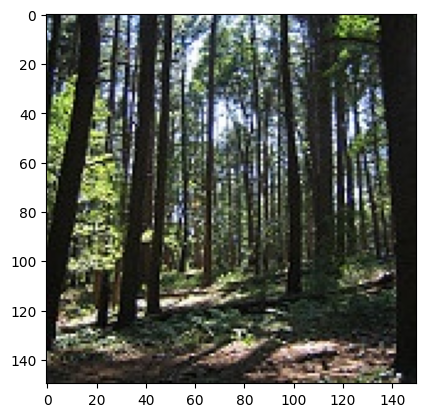


building sample image


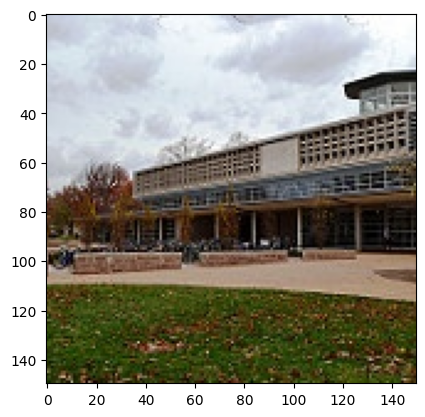

In [3]:
file_list = os.listdir(os.path.join(train_dir,'forest'))


print("forest sample image")
plt.imshow(load_img(f"{os.path.join(train_dir,'forest', os.listdir(os.path.join(train_dir,'forest'))[0])}" ))
plt.show()

print("\nbuilding sample image")
plt.imshow(load_img(f"{os.path.join(train_dir,'buildings', os.listdir(os.path.join(train_dir,'buildings'))[0])}"))
plt.show()

## Count training and testing files and inspect for zero lenght images

In [4]:

def count_files_in_folder(source_dir, new_path):
    
    #remove files with zero lenght and save in the new dirrectory 
    zero_length_files = []
    for dirr in os.listdir(source_dir):
        new_subdir = os.path.join(new_path, dirr)
        os.makedirs(new_subdir)
        for img in os.listdir(os.path.join(source_dir, dirr)):
            if os.path.getsize(os.path.join(source_dir, dirr, img)) !=0:
                copyfile(os.path.join(source_dir, dirr, img), os.path.join(new_subdir,img))
            else:
                zero_length_files.append(img)
                print(f"{img} is zero length, so ignoring")
        
    total_files = 0
    #Walk through all directories and subdirectories
    for root, dirs, files in os.walk(new_path):
        total_files += len(files)
    #directories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    #return directories
    if len(zero_length_files) == 0:
        print("No zero length files found.")

    return (total_files)

In [5]:
#train_files = count_files_in_folder(train_dir,train_path)
#test_files = count_files_in_folder(test_dir,test_path)

#print(f"There are {train_files} files in the training set")
#print(f"there are {test_files} files in the testing set")

## Creating Image Data Generators for loading the data and preprocing it

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   height_shift_range= 0.2,
                                    shear_range= 0.2,
                                     zoom_range= 0.2
                                  )

val_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 128, 
                                                    class_mode = 'sparse'
                                                   )
val_generator = val_datagen.flow_from_directory(directory = test_dir,
                                                target_size = (150, 150),
                                                batch_size = 64, 
                                                class_mode = 'sparse')



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## 1. Creating a basic model and testing different learining rate 

In [10]:
simple_model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(510, activation = 'relu'),
      tf.keras.layers.Dense(50, activation = 'relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(6, activation = 'softmax')
  ])
simple_model.compile(optimizer = Adam(learning_rate= 1e-6),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20)) 



In [12]:
simple_history = simple_model.fit(train_generator,
                   validation_data= val_generator,
                   epochs= 20 , callbacks=[lr_schedule]   #after the 20 epochs the model is starting to overfit
                   )

Epoch 1/20
110/110 [==============================] - 202s 2s/step - loss: 1.3779 - accuracy: 0.4553 - val_loss: 1.1860 - val_accuracy: 0.5400 - lr: 1.0000e-04
Epoch 2/20
110/110 [==============================] - 147s 1s/step - loss: 1.0962 - accuracy: 0.5747 - val_loss: 0.9889 - val_accuracy: 0.6177 - lr: 1.1220e-04
Epoch 3/20
110/110 [==============================] - 151s 1s/step - loss: 1.0108 - accuracy: 0.6170 - val_loss: 1.0067 - val_accuracy: 0.6207 - lr: 1.2589e-04
Epoch 4/20
110/110 [==============================] - 147s 1s/step - loss: 0.9452 - accuracy: 0.6385 - val_loss: 0.8969 - val_accuracy: 0.6700 - lr: 1.4125e-04
Epoch 5/20
110/110 [==============================] - 150s 1s/step - loss: 0.9002 - accuracy: 0.6650 - val_loss: 0.8021 - val_accuracy: 0.6997 - lr: 1.5849e-04
Epoch 6/20
110/110 [==============================] - 149s 1s/step - loss: 0.8447 - accuracy: 0.6841 - val_loss: 0.7394 - val_accuracy: 0.7367 - lr: 1.7783e-04
Epoch 7/20
110/110 [====================

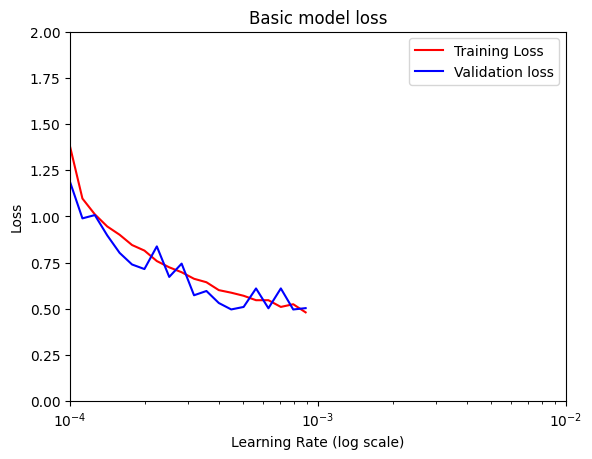

In [13]:
plt.semilogx(simple_history.history["lr"], simple_history.history["loss"], 'r', label='Training Loss')
plt.semilogx(simple_history.history["lr"], simple_history.history["val_loss"], 'b', label='Validation loss')
plt.title('Basic model loss')
plt.xlabel('Learning Rate (log scale)')  # Add x-axis label
plt.ylabel('Loss')  # Add y-axis label
plt.axis([1e-4, 10e-3, 0, 2])
plt.legend()
plt.show()

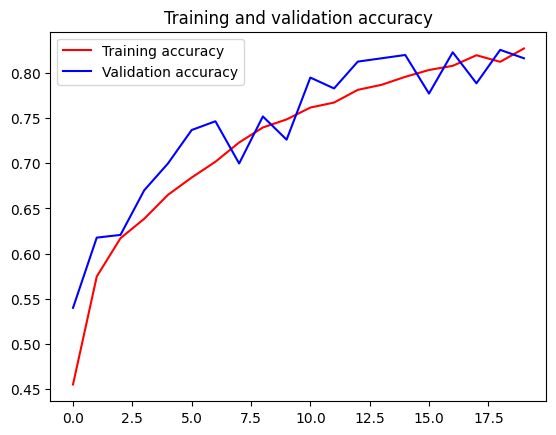

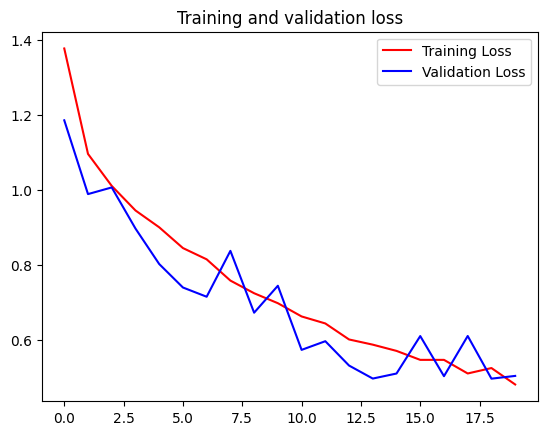

In [14]:
Train_acc = simple_history.history['accuracy']
val_acc = simple_history.history['val_accuracy']
train_loss = simple_history.history['loss']
val_loss = simple_history.history['val_loss']

epochs = range(len(Train_acc))

plt.plot(epochs, Train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## The basic model is overfitted to the training data. I will choose 2.8184e-04 as the alpha value since the model is still learning at this point. 

## 2. Creating a model using Transfer Learning from inceptionV3

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [16]:
base_model = InceptionV3(input_shape = ( 150 , 150 , 3),       #here the res and the dimention
                                  include_top = False)
base_model.trainable = False
base_model.summary()


87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d_7[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [17]:
trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])
print(f"Number of trainable parameter in the base model: {trainable_params:,} ")

Number of trainable parameter in the base model: 0 


In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.23):
      print("\nReached 0.23 % val_loss so cancelling training!")
      self.model.stop_training = True

In [24]:
desired_layer = base_model.get_layer('mixed7')
last_output = desired_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(units = 55, activation = 'relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense( units = 6, activation = 'softmax')(x)
tr_model = Model(inputs = base_model.input, outputs = x)

tr_model.compile(optimizer = Adam(learning_rate= 1.5e-4),
              loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [25]:
callbacks = myCallback()
tr_history = tr_model.fit(train_generator,
                    validation_data= val_generator,
                   epochs= 25
                   ,callbacks= callbacks
                         )

Epoch 1/25
110/110 [==============================] - 234s 2s/step - loss: 0.4876 - accuracy: 0.8292 - val_loss: 0.2583 - val_accuracy: 0.9100
Epoch 2/25
110/110 [==============================] - 223s 2s/step - loss: 0.2865 - accuracy: 0.9010 - val_loss: 0.2368 - val_accuracy: 0.9200
Epoch 3/25
110/110 [==============================] - 227s 2s/step - loss: 0.2537 - accuracy: 0.9131 - val_loss: 0.2413 - val_accuracy: 0.9147
Epoch 4/25
110/110 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9203
Reached 0.23 % val_loss so cancelling training!
110/110 [==============================] - 230s 2s/step - loss: 0.2316 - accuracy: 0.9203 - val_loss: 0.2218 - val_accuracy: 0.9213


## Model prediction 

## Run the cell below to see the prediction of the model for random set new images on each run. 


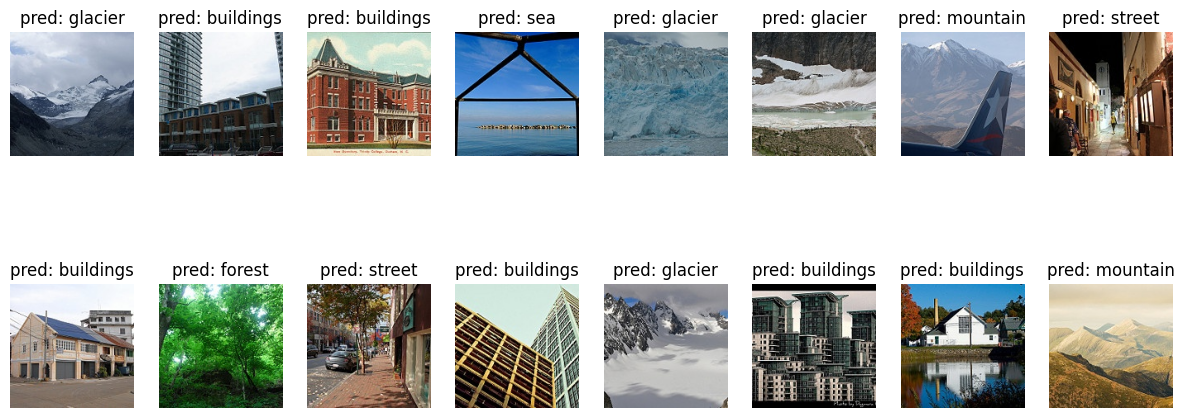

In [29]:
from matplotlib import axis


def display_image_pred (img_path, model_x):
    class_labels = list(train_generator.class_indices.keys()) 
    image_files = [file for file in os.listdir(img_path) if file.lower().endswith('.jpg')]
# Ensure that you have at least 40 images in the list
#if len(image_files) < 40:
    #raise ValueError("There are fewer than 40 images with the .jpg extension in the specified directory.")


    fig, axes = plt.subplots(2,8, figsize=(15, 6))
    for i, ax in enumerate(axes.ravel()):
        random_image = random.sample(image_files, 1)
        image_path = os.path.join(pred_dir, random_image[0])
        img = load_img(image_path, target_size=(150, 150))
        img = img_to_array(img)
        img /= 255
        x2 = np.expand_dims(img, axis=0)
        #print(shape(x))
        pred = model_x.predict(x2, batch_size=1, verbose=0)
        pred_class_ind = np.argmax(pred, axis=1)
        pred_class_lab = [class_labels[i] for i in pred_class_ind] #name of the predicted class 
        ax.imshow(img)
        ax.set_title("pred: " +pred_class_lab[0])
        ax.axis("off")

    plt.show()

display_image_pred (pred_dir, tr_model)

## upload data for prediction 

In [30]:
import tkinter as tk
from tkinter import filedialog

In [31]:
def ask_for_image_path():
    root = tk.Tk()
    root.withdraw()

    file_path = filedialog.askopenfilename(title="Select Image File", filetypes=[("Image files", "*.png;*.jpg;*.jpeg;*.gif;*.bmp")])

    return file_path

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))  # Adjust target_size based on your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [33]:

#image_path = ask_for_image_path()
#processed_image = preprocess_image(image_path)
# Make predictions
#predictions = model.predict(processed_image)
#decoded_predictions = decode_predictions(predictions)

# Print the top predicted class and probability
#top_prediction = decoded_predictions[0][0]
#print(f"Predicted class: {top_prediction[1]}, Probability: {top_prediction[2]}")

# Now you can use the image_path variable to load or process the image